In [85]:
! pip install transformers
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup
import tqdm.auto as tqdm
import torch.nn.functional as F
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score,f1_score,roc_curve
from torch import nn,optim
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 4
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/glen/glen.csv")
print(df.info(),len(df['name'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4709 entries, 0 to 4708
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DWD              4709 non-null   object
 1   name             4709 non-null   object
 2   wd_description   4709 non-null   object
 3   overlay_parents  4700 non-null   object
 4   Unnamed: 4       60 non-null     object
 5   Unnamed: 5       3 non-null      object
dtypes: object(6)
memory usage: 220.9+ KB
None 4348


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4709 entries, 0 to 4708
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DWD              4709 non-null   object
 1   name             4709 non-null   object
 2   wd_description   4709 non-null   object
 3   overlay_parents  4700 non-null   object
 4   Unnamed: 4       60 non-null     object
 5   Unnamed: 5       3 non-null      object
dtypes: object(6)
memory usage: 220.9+ KB


In [89]:
name_count = df.name.value_counts()
len(df.loc[df['name'].isin(name_count.index[name_count > 0])])
df = df.loc[df['name'].isin(name_count.index[name_count > 0])]

In [90]:
# print(df['name'].unique())
name_count = df.name.value_counts()
print(name_count)

flight                          5
motion                          5
competition                     4
order                           4
cancellation                    4
                               ..
epidemiological_surveillance    1
epidural_injection              1
epilation                       1
epileptic_seizure               1
public_pollution                1
Name: name, Length: 4348, dtype: int64


In [ ]:
idToLabel = {str(index): label for index, label in enumerate(df['name'].unique())};
labelToId = {value: key for key, value in idToLabel.items()};

In [ ]:
len(labelToId)

300

Text(0.5, 0, 'category')

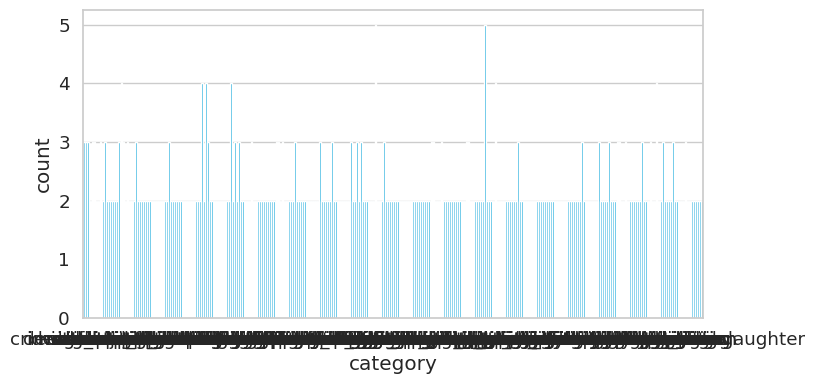

In [ ]:
#check for imblanced classes
sns.countplot(data= df,x="name")
plt.xlabel('category')

In [ ]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
Unnamed: 5,660,0.998487
Unnamed: 4,650,0.983359
overlay_parents,1,0.001513
DWD,0,0.000000
name,0,0.000000
wd_description,0,0.000000


In [ ]:
#check for dublicated rows
print("Numbers of duplicated rows :",df.duplicated().sum())

Numbers of duplicated rows : 0


EDA and Preprocessing


<Axes: title={'center': 'frequency of event name'}, xlabel='name'>

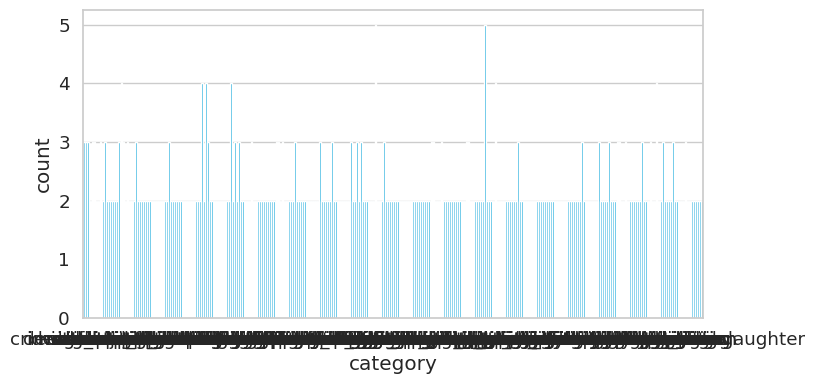

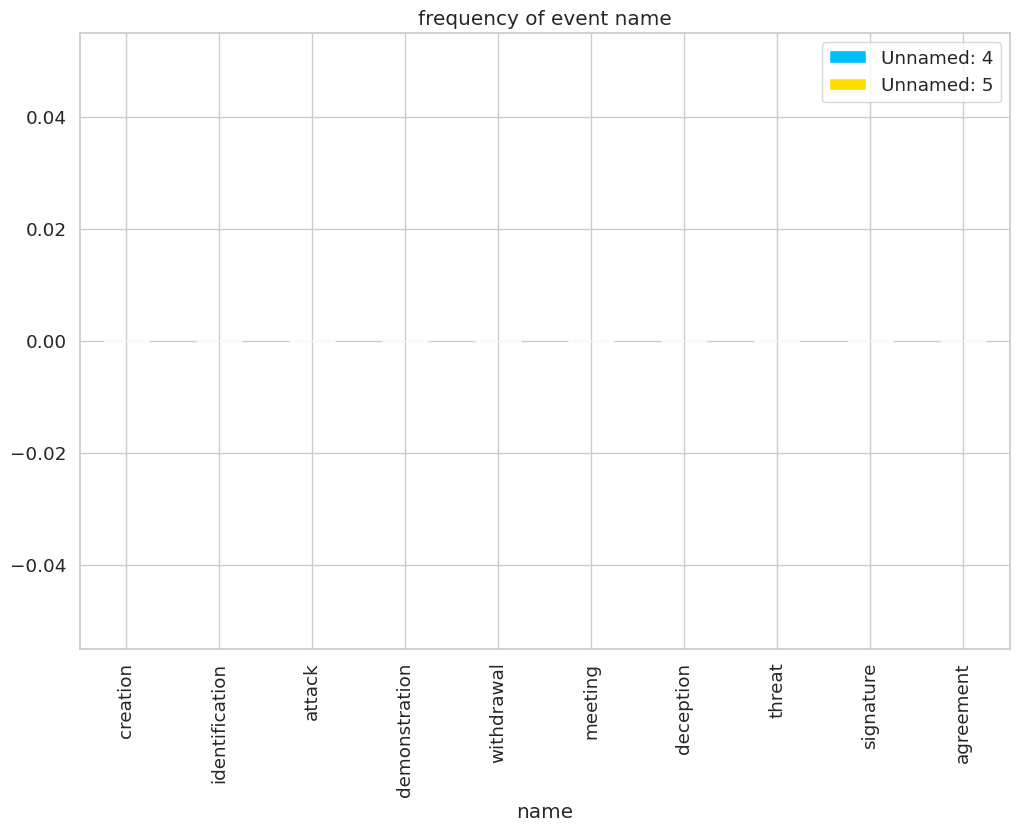

In [ ]:
#check for imblanced classes
sns.countplot(data=df,x="name")
plt.xlabel('category')
df[0:10].plot.bar(x='name', figsize=(12,8), title='frequency of event name')


In [ ]:
# #counting text length
# df['count'] = df['wd_description'].str.split().str.len()

# # Remove the text with words less than 3
# df= df.loc[df['count']>3]


In [ ]:
name_cat = list(df.name.unique())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 4 to 4680
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DWD              661 non-null    object
 1   name             661 non-null    object
 2   wd_description   661 non-null    object
 3   overlay_parents  660 non-null    object
 4   Unnamed: 4       11 non-null     object
 5   Unnamed: 5       1 non-null      object
dtypes: object(6)
memory usage: 36.1+ KB


In [ ]:
import re
def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    # english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    # text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROer012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
df['cleanText'] = df.wd_description.apply(lambda x: preprocessing(str(x)))

Stopword Removing

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords



In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop = list(stopwords.words('english'))

In [ ]:
df.head()

,DWD,name,wd_description,overlay_parents,Unnamed: 4,Unnamed: 5,cleanText
4,DWD_Q11398090,creation,process during which something comes into bein...,activity,NaN,NaN,pocss duing which somthing coms into bing and ...
14,DWD_Q3265221,identification,mapping of a known quantity to an unknown enti...,connection,NaN,NaN,mapping of a known quantity to an unknown ntit...
33,DWD_Q1174599,attack,action to injure another organism,action,NaN,NaN,action to inju anoth oganism
37,DWD_Q175331,demonstration,collective action by people in favor of a cause,eventprotest,NaN,NaN,collctiv action by popl in favo of a caus
38,DWD_Q1760704,withdrawal,military operation,military_operation,NaN,NaN,militay opation


In [ ]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [ ]:
df['cleanText'] = df.cleanText.apply(lambda x: stopwordRemoval(str(x)))

In [ ]:
df=df[["cleanText","name"]]
print(df.shape)

(661, 2)


In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review.
# token_lens = []

# for txt in df.cleanText:
#     tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
#     token_lens.append(len(tokens))

# sns.distplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count')

In [ ]:
# Import label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df['name']= le.fit_transform(df['name'])

Feature Selection Correlation

ML

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['cleanText'], df['name'], test_size=0.2)

In [ ]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,accuracy_score
from sklearn.linear_model import LogisticRegression,RidgeClassifier,LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


In [ ]:
# linear regression
lr=LogisticRegression()
lr.fit(x_train, y_train)
y_pred=lr.predict(x_test)
print("Accuracy :--->>",accuracy_score(y_test,y_pred))
print()
print(classification_report(y_test,y_pred))
print()
print()
print("Confusion matrix:--->>\n",confusion_matrix(y_test,y_pred))
print()
print()
print("precision:--->>\n",precision_score(y_test,y_pred,average=('weighted')))
print()
print()
print("recall:--->>\n",recall_score(y_test,y_pred,average=('weighted')))
print()
print()
print("f1_score:--->>\n",f1_score(y_test,y_pred,average=('weighted')))
print()
print("\n<<<<------------------------------------------------------------->>>>\n")

Accuracy :--->> 0.007518796992481203

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00

In [ ]:
# svc
svc=SVC()
svc.fit(x_train, y_train)
y_pred=svc.predict(x_test)
print("Accuracy :--->>",accuracy_score(y_test,y_pred))
print()
print(classification_report(y_test,y_pred))
print()
print()
print("Confusion matrix:--->>\n",confusion_matrix(y_test,y_pred))
print()
print()
print("precision:--->>\n",precision_score(y_test,y_pred,average=('weighted')))
print()
print()
print("recall:--->>\n",recall_score(y_test,y_pred,average=('weighted')))
print()
print()
print("f1_score:--->>\n",f1_score(y_test,y_pred,average=('weighted')))
print()
print("\n<<<<------------------------------------------------------------->>>>\n")

Accuracy :--->> 0.007518796992481203

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00

In [ ]:
# Naive bais
gs=MultinomialNB()
gs.fit(x_train, y_train)
y_pred=gs.predict(x_test)
print("Accuracy :--->>",accuracy_score(y_test,y_pred))
print()
print(classification_report(y_test,y_pred))
print()
print()
print("Confusion matrix:--->>\n",confusion_matrix(y_test,y_pred))
print()
print()
print("precision:--->>\n",precision_score(y_test,y_pred,average=('weighted')))
print()
print()
print("recall:--->>\n",recall_score(y_test,y_pred,average=('weighted')))
print()
print()
print("f1_score:--->>\n",f1_score(y_test,y_pred,average=('weighted')))
print()
print("\n<<<<------------------------------------------------------------->>>>\n")

Accuracy :--->> 0.0

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       2.0
           9       0.00      0.00      0.00       2.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       1.0
          16       0.00      0.00      0.00       2.0
          17       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       1.0
          21       0.00      0.00      0.00       1.0
          22       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          26       0.00      0.00      0.00       1.0
          27       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00       3.0
      